In [346]:
# load and autoreload
from IPython import get_ipython
# noinspection PyBroadException
try:
    _magic = get_ipython().magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass
    

import os 
import glob
import sys
import pprint
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt 
import xarray as xr 
import seaborn as sns
import cartopy as crt

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [347]:
adm_dic=pd.read_csv('./data/adm_dic.csv')

In [348]:
# fix uruguay missing data

In [349]:
ur = adm_dic[adm_dic['country']=='Uruguay'].copy()

In [350]:
dur = 22324

In [351]:
ur['fix']=ur['pop'] * dur / ur['pop'].sum()/6

In [352]:
ur

,mname,pop,country,adm,admi,fix
152,"Artigas, Uruguay",73378.0,Uruguay,Artigas,UY-AR,83.076382
153,"Canelones, Uruguay",520187.0,Uruguay,Canelones,UY-CA,588.940202
154,"Cerro Largo, Uruguay",84698.0,Uruguay,Cerro Largo,UY-CL,95.892549
155,"Colonia, Uruguay",123203.0,Uruguay,Colonia,UY-CO,139.486761
156,"Durazno, Uruguay",57088.0,Uruguay,Durazno,UY-DU,64.633330
157,"Flores, Uruguay",25050.0,Uruguay,Flores,UY-FS,28.360863
158,"Florida, Uruguay",67048.0,Uruguay,Florida,UY-FD,75.909745
159,"Lavalleja, Uruguay",58815.0,Uruguay,Lavalleja,UY-LA,66.588588
160,"Maldonado, Uruguay",164300.0,Uruguay,Maldonado,UY-MA,186.015558
161,"Montevideo, Uruguay",1319108.0,Uruguay,Montevideo,UY-MO,1493.454723


In [353]:
f = './data/south.america.subnational.mortality.txt'

In [354]:
df = pd.read_csv(f)

In [355]:
IC,CN,AI,AN,FR,DT,DE = ('iso_code', 'country_name', 'adm1_isocode', 'adm1_name', 'frequency',
       'date', 'deaths')

In [356]:
nam = df.drop_duplicates([CN,AN])[[CN,AN,AI]]

In [357]:
con = df.drop_duplicates(CN)[CN]

In [358]:
for i in con:
    pprint.pprint(nam[nam[CN]==i])

    country_name   adm1_name adm1_isocode
0        Bolivia        Beni         BO-B
33       Bolivia  Chuquisaca         BO-H
66       Bolivia  Cochabamba         BO-C
99       Bolivia      La Paz         BO-L
132      Bolivia       Oruro         BO-O
165      Bolivia       Pando         BO-N
198      Bolivia      Potosi         BO-P
231      Bolivia  Santa Cruz         BO-S
264      Bolivia      Tarija         BO-T
      country_name            adm1_name adm1_isocode
297         Brazil                 Acre        BR-AC
1750        Brazil              Alagoas        BR-AL
3206        Brazil                Amapa        BR-AP
4653        Brazil             Amazonas        BR-AM
6107        Brazil                Bahia        BR-BA
7563        Brazil                Ceara        BR-CE
9018        Brazil       Espirito Santo        BR-ES
10473       Brazil     Federal District        BR-DF
11928       Brazil                Goias        BR-GO
13384       Brazil             Maranhao        BR-

In [359]:
nam.to_csv('./data/coun_adm.csv')

In [360]:
cdf = pd.read_csv('./data/city_data.csv',na_values='QuantityMagnitude[Missing["NotAvailable"]]')
cdf['Elevation'] = cdf['Elevation']/1000

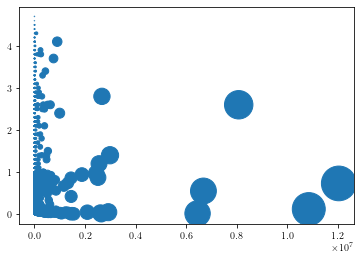

In [361]:
plt.scatter(cdf['Population'],cdf['Elevation'],s=cdf['Population']/10000)

In [362]:
g1= cdf.groupby('AdministrativeDivision')
g= cdf.groupby('Country')

In [363]:
g['Population'].sum()

Country
Bolivia       6480392
Brazil      157831577
Chile        17943835
Colombia     39736325
Ecuador      10688524
Paraguay      4470748
Peru         21902526
Uruguay       3091253
Name: Population, dtype: int64

In [364]:
c1 = cdf[cdf['Elevation'].notna()].copy()
c1['pop_el'] = c1['Population']*c1['Elevation']

In [365]:
g1 = c1.groupby('AdministrativeDivision')

In [366]:
wh = (g1['pop_el'].sum()/g1['Population'].sum())
wh.name = 'weighted_height'
div = wh.to_frame()

In [367]:
div['pop'] = g1['Population'].sum()

In [368]:
from statsmodels.stats.weightstats import DescrStatsW

In [369]:
st = {}
for g,v in g1:
    values = v['Elevation']
    weights = v['Population']
    st[g]=DescrStatsW(values, weights=weights, ddof=1).std
st = pd.Series(st)

In [370]:
div['stw']=st

In [371]:
d1 = div.sort_values('pop',ascending=False)

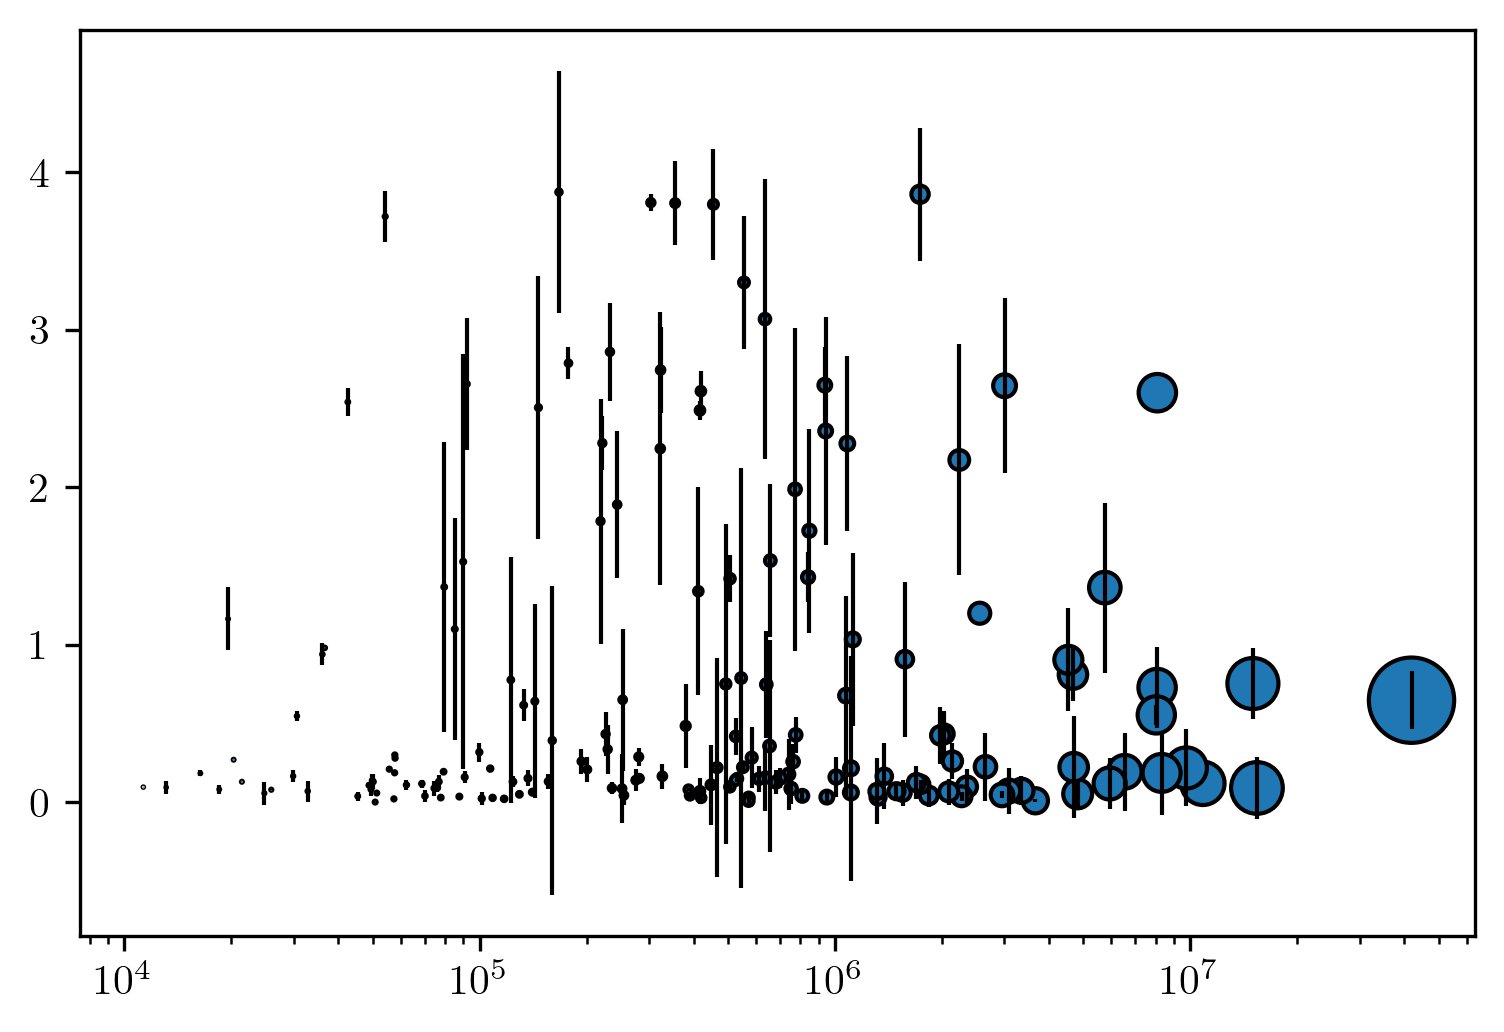

In [372]:
f,ax = plt.subplots(dpi=300)

ax.scatter(d1['pop'],d1['weighted_height'],s=d1['pop']/100000,edgecolors='k')
ax.errorbar(d1['pop'],d1['weighted_height'],yerr=d1['stw'],lw=0,elinewidth=1,zorder=100,c='k')
ax.set_xscale('log')

In [373]:
df['dt']=pd.to_datetime(df['date'])
df1 = df.set_index('dt')


In [374]:
ur1 = ur.set_index('admi')['fix']

In [375]:
ur1.sum() * 6

22324.0

In [376]:
df2=df1.groupby(['adm1_isocode',pd.Grouper(freq='M')]).sum()['deaths'].unstack().T

In [377]:
ddd = df2[(df2.index > '2021') & (df2.index < '2021-07')].copy()[ur1.index]

In [378]:
df2_ = (ddd.fillna(0) + ur1)

In [379]:
df2_

adm1_isocode,UY-AR,UY-CA,UY-CL,UY-CO,UY-DU,UY-FS,UY-FD,UY-LA,UY-MA,UY-MO,UY-PA,UY-RN,UY-RV,UY-RO,UY-SA,UY-SJ,UY-SO,UY-TA,UY-TT
dt,,,,,,,,,,,,,,,,,,,
2021-01-31,83.076382,588.940202,95.892549,139.486761,64.63333,28.360863,75.909745,66.588588,186.015558,1493.454723,128.075618,62.003299,117.171687,77.087202,141.383146,122.624219,93.511595,101.95532,54.495879
2021-02-28,83.076382,588.940202,95.892549,139.486761,64.63333,28.360863,75.909745,66.588588,186.015558,1493.454723,128.075618,62.003299,117.171687,77.087202,141.383146,122.624219,93.511595,101.95532,54.495879
2021-03-31,83.076382,588.940202,95.892549,139.486761,64.63333,28.360863,75.909745,66.588588,186.015558,1493.454723,128.075618,62.003299,117.171687,77.087202,141.383146,122.624219,93.511595,101.95532,54.495879
2021-04-30,83.076382,588.940202,95.892549,139.486761,64.63333,28.360863,75.909745,66.588588,186.015558,1493.454723,128.075618,62.003299,117.171687,77.087202,141.383146,122.624219,93.511595,101.95532,54.495879
2021-05-31,83.076382,588.940202,95.892549,139.486761,64.63333,28.360863,75.909745,66.588588,186.015558,1493.454723,128.075618,62.003299,117.171687,77.087202,141.383146,122.624219,93.511595,101.95532,54.495879
2021-06-30,83.076382,588.940202,95.892549,139.486761,64.63333,28.360863,75.909745,66.588588,186.015558,1493.454723,128.075618,62.003299,117.171687,77.087202,141.383146,122.624219,93.511595,101.95532,54.495879


In [380]:
df2.loc[df2_.index,df2_.columns] = df2_

In [381]:
df3 = df2['2019-01-01':'2019-12-31']

In [382]:
df3.index = df3.index.month

In [383]:
df3.isna().sum().sum()

0

In [384]:
mm = df2['2020-03':'2021-07']

In [385]:
mm.index = mm.index.month

In [386]:
m2 = mm.sum()/(mm * 0 + df3).sum()

In [387]:
m1 = (mm/df3).mean()

In [388]:
# m1.plot()
# m2.plot()
# ax = plt.gca()
# ax.axhline(1)
# ax.set_ylim(0.5,3)

In [389]:
adm_dic

,mname,pop,country,adm,admi
0,"Beni, Bolivia",421196.0,Bolivia,Beni,BO-B
1,"Chuquisaca, Bolivia",576153.0,Bolivia,Chuquisaca,BO-H
2,"Cochabamba, Bolivia",1930143.0,Bolivia,Cochabamba,BO-C
3,"La Paz, Bolivia",2706359.0,Bolivia,La Paz,BO-L
4,"Oruro, Bolivia",494178.0,Bolivia,Oruro,BO-O
...,...,...,...,...,...
166,"Salto, Uruguay",124878.0,Uruguay,Salto,UY-SA
167,"San Jose, Uruguay",108309.0,Uruguay,San Jose,UY-SJ
168,"Soriano, Uruguay",82595.0,Uruguay,Soriano,UY-SO
169,"Tacuarembo, Uruguay",90053.0,Uruguay,Tacuarembo,UY-TA


In [390]:
m2.name='ratio'
m3 = m2.to_frame()

In [391]:
f1 = pd.merge(m2,adm_dic,left_index=True, right_on='admi',how='inner',
         validate='1:1')

In [392]:
f1

,ratio,mname,pop,country,adm,admi
0,1.542251,"Beni, Bolivia",421196.0,Bolivia,Beni,BO-B
2,1.506961,"Cochabamba, Bolivia",1930143.0,Bolivia,Cochabamba,BO-C
1,1.355171,"Chuquisaca, Bolivia",576153.0,Bolivia,Chuquisaca,BO-H
3,1.756581,"La Paz, Bolivia",2706359.0,Bolivia,La Paz,BO-L
5,1.923077,"Pando, Bolivia",110436.0,Bolivia,Pando,BO-N
...,...,...,...,...,...,...
166,1.110166,"Salto, Uruguay",124878.0,Uruguay,Salto,UY-SA
167,1.219859,"San Jose, Uruguay",108309.0,Uruguay,San Jose,UY-SJ
168,1.129210,"Soriano, Uruguay",82595.0,Uruguay,Soriano,UY-SO
169,1.100026,"Tacuarembo, Uruguay",90053.0,Uruguay,Tacuarembo,UY-TA


In [393]:
f2 = pd.merge(d1.drop('pop',axis=1),f1,left_index=True,
         right_on='mname',validate='1:1')

f2 = f2.sort_values('pop',ascending=False)
f2 = f2[f2['ratio']<5]
bo=f2['country']=='Brazil'
# f2 = f2[bo]

cme = f2.groupby('country').median()

f2 = pd.merge(cme,f2,left_on='country',right_on='country',suffixes=['_r',''])
# f2['ratio']=f2['ratio']/f2['ratio_r']

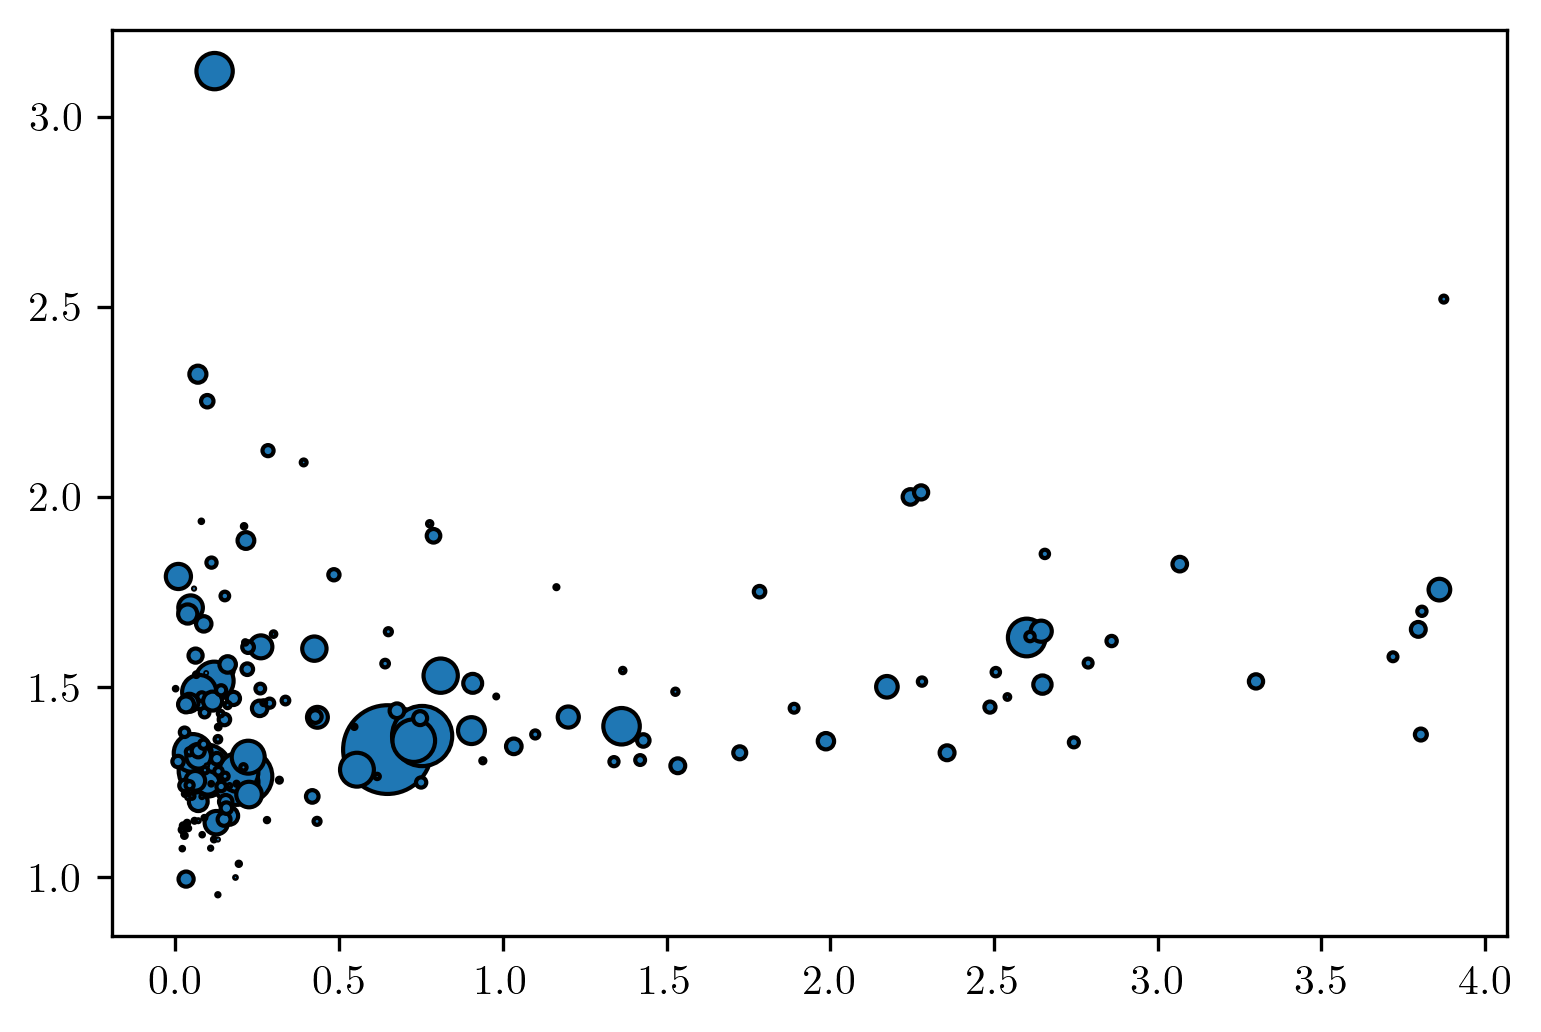

In [394]:
f,ax= plt.subplots(dpi=300)
ax.scatter(
    f2['weighted_height'],
    f2['ratio'],
    s=f2['pop']/100000,
    edgecolors='k'
)
# ax.set_ylim(.5,3)

In [395]:
mea = f2['ratio'].mean()

wmea = (f2['ratio']*f2['pop']).sum()/f2['pop'].sum()

In [396]:
co = f2['country']

In [397]:
dic_ = co.drop_duplicates().reset_index(drop=True).reset_index().set_index('country')['index'].to_dict()

In [398]:
f2['ci']=f2['country'].replace(dic_)

In [399]:
cm = plt.get_cmap('tab10')

In [400]:
cs = [cm(i) for l,i in f2['ci'].items()]

In [401]:
from sklearn.linear_model import QuantileRegressor,LinearRegression

In [402]:
qr = QuantileRegressor(alpha=0)
qr1 = LinearRegression()
qr2 = LinearRegression()

In [403]:
from sklearn.preprocessing import StandardScaler

In [404]:
f2_ = f2.sort_values('weighted_height')
X = f2_[['weighted_height']]
y = f2_[['ratio']]

In [405]:
s1 = StandardScaler()
s2 = StandardScaler()

In [406]:
X1 = s1.fit_transform(X)
y1 = s2.fit_transform(y)

In [407]:
qr.fit(X1,y1[:,0])
qr1.fit(X1,y1[:,0])
qr2.fit(X,y.values[:,0])

LinearRegression()

In [408]:
yp11 = qr.predict(X1)
yp12 = qr1.predict(X1)
yp13 = qr2.predict(X)

In [409]:
yp111 = s2.inverse_transform(yp11.reshape(-1,1))[:,0]
yp112 = s2.inverse_transform(yp12.reshape(-1,1))[:,0]

(0.75, 2.8)

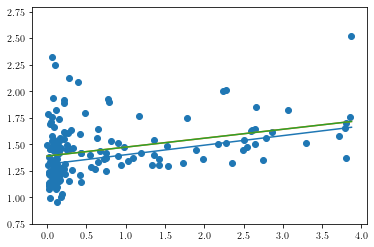

In [410]:
plt.plot(X.values[:,0],yp111)
plt.plot(X.values[:,0],yp112)
plt.plot(X.values[:,0],yp13)
plt.scatter(X.values[:,0],y.values[:,0])
plt.gca().set_ylim(.75,2.8)

In [411]:
means = {}
wmeans_ = {}
fits = {}
f_xy = {}
for c in dic_.keys():
    boo = f2['country']==c
    means[c]=f2[boo]['ratio'].mean()
    _f = f2[boo].sort_values('weighted_height')
    wm = (_f['ratio'] * _f['pop']).sum()/_f['pop'].sum()
    wmeans_[c]=wm
    
    
    lr = QuantileRegressor(alpha=0)
#     lr = LinearRegression()
    _X = _f[['weighted_height']]
    _y = _f['ratio']
    lr.fit(_X,_y)
    fits[c] = lr
    f_xy[c] = [_X.values[:,0],lr.predict(_X)]
    

In [412]:
means = pd.Series(means).sort_values(ascending=False).to_dict()
dic = {}
wmeans = {}
for i,v in means.items():
    dic[i] = dic_[i]
    wmeans[i] = wmeans_[i]
    

<AxesSubplot:>

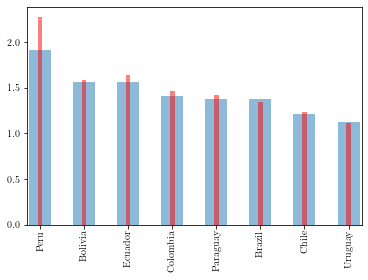

In [413]:
pd.Series(means).plot.bar(alpha=.5)
pd.Series(wmeans).plot.bar(alpha=.5,color='r',width=.1)

In [414]:


doff = {
    'Peru': 0,
     'Bolivia': 0,
     'Ecuador': .01,
     'Colombia': -.01,
     'Brazil': 0,
     'Paraguay': 0,
     'Chile': 0,
     'Uruguay': 0
}

In [584]:
coef=results.summary2().tables[1]['Coef.']['x1']

In [591]:
# fy = f' $y = {qr2.coef_[0]:.2f}x + {qr2.intercept_:.2f}$'

# pval = results.summary2().tables[1]['P>|t|']['x1']

# fy = f'  $y = {coef:.2f} ({x1:.2f},{x2:.2f}) x + {qr2.intercept_:.2f}({c1:.2f},{c2:.2f})\\ |\\ p_{{\\rm{{val}}}}={pval:.2f}$'


_x = f2_['weighted_height'].values
_y = f2_['ratio'].values

import statsmodels.api as sm
import numpy as np

# include constant in ols models, which is not done by default
_x = sm.add_constant(_x)

model = sm.OLS(_y,_x)
results = model.fit()

s=results.summary2()
c1,x1 = s.tables[1]['[0.025']
c2,x2 = s.tables[1]['0.975]']


fy = f'$y = {coef:.2f}x + {qr2.intercept_:.2f}$'

pval = results.summary2().tables[1]['P>|t|']['x1']

fy = f'  $y = {coef:.2f} ({x1:.2f},{x2:.2f}) x + {qr2.intercept_:.2f}({c1:.2f},{c2:.2f})\\ |\\ p_{{\\rm{{val}}}}={pval:.2f}$'

In [592]:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

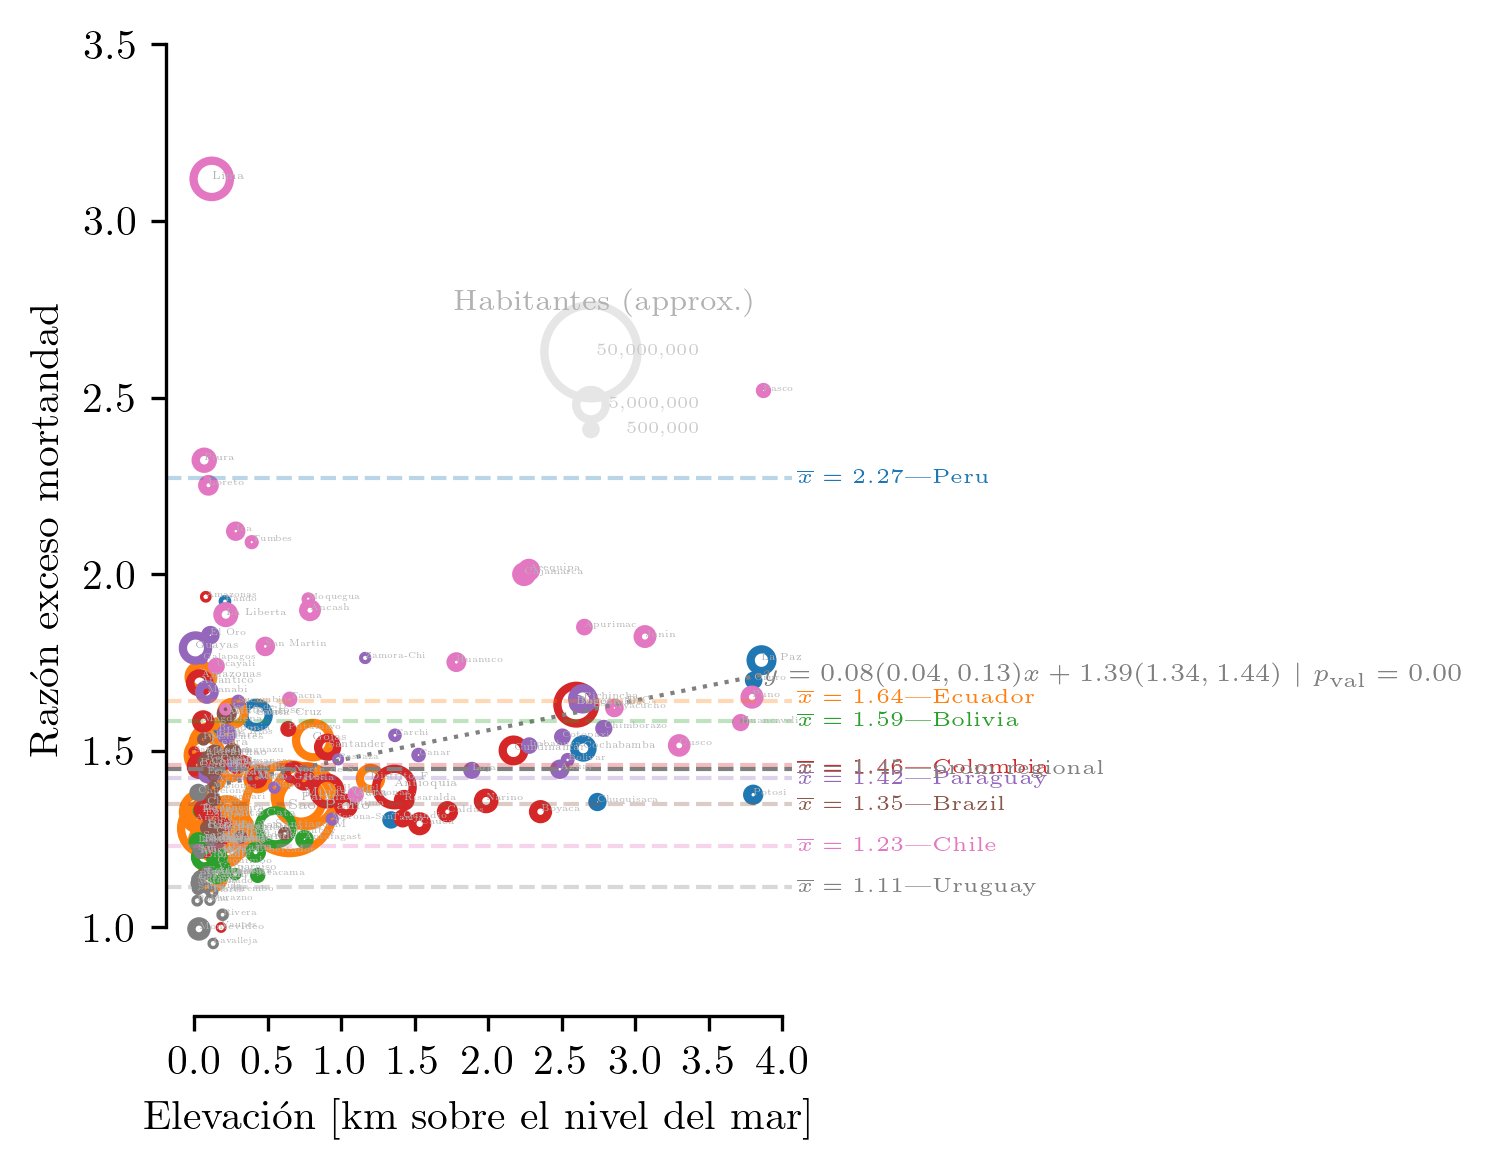

In [593]:
f,ax= plt.subplots(dpi=300,figsize=(5,4))
ax.scatter(
    f2['weighted_height'],
    f2['ratio'],
    s=f2['pop']/100000,
    edgecolors=cs,
    lw=2,
    facecolor='none'
)
ax.set_ylim(.75,3.5)
ax.axhline(wmea,c='.5',ls='--',lw=1)
ax.plot(X.values[:,0],yp13,ls=':',c='.5',lw=1)
ax.text(X.values[-1,0],yp13[-1],fy,va='center',fontsize=6,c='.5')


sns.despine(f,trim=True)
ax.set_ylabel('Razón exceso mortandad')
ax.set_xlabel('Elevación [km sobre el nivel del mar]')

# al = {0:'bottom',1:'top'}

for i,c in enumerate(dic.keys()):
    ax.axhline(wmeans[c],alpha=.3,lw=1,ls='--',c=cm(dic[c]))
#   ax.plot(*f_xy[c],ls='-.',lw=1,alpha=.5)
#   ax.text(.5,1-i/20,c,transform=ax.transAxes,c=cm(dic[c]))
    ax.text(4.1,wmeans[c]+doff[c],f'$\overline{{x}}={wmeans[c]:.2f}$|{c}',
            fontsize=5,c=cm(dic[c]),va='center')
    pass

ax.text(4.1,wmea,f'$\overline{{x}}={wmea:.2f}$|prom regional',
        fontsize=5,c='.5',va='center')

for i,r in f2.iterrows():
    ax.text(r['weighted_height'],r['ratio'],
           r['adm'][:10], fontsize = (r['pop'])**.5/5000+2,
            c='.7'
           )
xx = [2.7,2.7,2.7]
yy = [2.63,2.48,2.41]
pp = [5e7,5e6,5e5]
ax.scatter(
    xx,
    yy,
    s=np.array(pp)/100000,
    lw=2,
    facecolor='none',
    edgecolor='.9')

for x,y,p in zip(xx,yy,pp):
    ax.text(x+.75,y,f'{int(p):,}',va='center',ha='right',fontsize=4,c='.8')
    
ax.text(xx[0]+.1,2.75,'Habitantes (approx.)',fontsize=7,c='.7',ha='center')
f.tight_layout()
f.savefig('reg_alt.pdf')
f.savefig('reg_alt.png')

Notas: datos de uruguay corregidos a groso modo con info de acá:
https://www.gub.uy/ministerio-salud-publica/comunicacion/noticias/cifras-preliminares-mortalidad-segun-causa-muerte-primer-semestre-2021

- este resultado muy probablemnte peca de "falacia ecológica"

In [420]:
f2

,country,weighted_height_r,stw_r,ratio_r,pop_r,weighted_height,stw,ratio,mname,pop,adm,admi,ci
0,Bolivia,2.647915,0.241489,1.542251,576153.0,0.424662,0.179002,1.601459,"Santa Cruz, Bolivia",3412921.0,Santa Cruz,BO-S,0
1,Bolivia,2.647915,0.241489,1.542251,576153.0,3.860132,0.421739,1.756581,"La Paz, Bolivia",2706359.0,La Paz,BO-L,0
2,Bolivia,2.647915,0.241489,1.542251,576153.0,2.647915,0.241489,1.506961,"Cochabamba, Bolivia",1930143.0,Cochabamba,BO-C,0
3,Bolivia,2.647915,0.241489,1.542251,576153.0,3.803522,0.268544,1.375703,"Potosi, Bolivia",823517.0,Potosi,BO-P,0
4,Bolivia,2.647915,0.241489,1.542251,576153.0,2.743848,0.273781,1.355171,"Chuquisaca, Bolivia",576153.0,Chuquisaca,BO-H,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Uruguay,0.039539,0.019047,1.125518,84698.0,0.129979,0.047283,0.954624,"Lavalleja, Uruguay",58815.0,Lavalleja,UY-LA,7
161,Uruguay,0.039539,0.019047,1.125518,84698.0,0.107898,0.016420,1.076963,"Durazno, Uruguay",57088.0,Durazno,UY-DU,7
162,Uruguay,0.039539,0.019047,1.125518,84698.0,0.038284,0.027465,1.210298,"Rio Negro, Uruguay",54765.0,Rio Negro,UY-RN,7
163,Uruguay,0.039539,0.019047,1.125518,84698.0,0.070170,0.067115,1.149193,"Treinta y Tres, Uruguay",48134.0,Treinta y Tres,UY-TT,7


In [421]:
f2

,country,weighted_height_r,stw_r,ratio_r,pop_r,weighted_height,stw,ratio,mname,pop,adm,admi,ci
0,Bolivia,2.647915,0.241489,1.542251,576153.0,0.424662,0.179002,1.601459,"Santa Cruz, Bolivia",3412921.0,Santa Cruz,BO-S,0
1,Bolivia,2.647915,0.241489,1.542251,576153.0,3.860132,0.421739,1.756581,"La Paz, Bolivia",2706359.0,La Paz,BO-L,0
2,Bolivia,2.647915,0.241489,1.542251,576153.0,2.647915,0.241489,1.506961,"Cochabamba, Bolivia",1930143.0,Cochabamba,BO-C,0
3,Bolivia,2.647915,0.241489,1.542251,576153.0,3.803522,0.268544,1.375703,"Potosi, Bolivia",823517.0,Potosi,BO-P,0
4,Bolivia,2.647915,0.241489,1.542251,576153.0,2.743848,0.273781,1.355171,"Chuquisaca, Bolivia",576153.0,Chuquisaca,BO-H,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Uruguay,0.039539,0.019047,1.125518,84698.0,0.129979,0.047283,0.954624,"Lavalleja, Uruguay",58815.0,Lavalleja,UY-LA,7
161,Uruguay,0.039539,0.019047,1.125518,84698.0,0.107898,0.016420,1.076963,"Durazno, Uruguay",57088.0,Durazno,UY-DU,7
162,Uruguay,0.039539,0.019047,1.125518,84698.0,0.038284,0.027465,1.210298,"Rio Negro, Uruguay",54765.0,Rio Negro,UY-RN,7
163,Uruguay,0.039539,0.019047,1.125518,84698.0,0.070170,0.067115,1.149193,"Treinta y Tres, Uruguay",48134.0,Treinta y Tres,UY-TT,7


In [422]:
d1 = f2

In [423]:
R = 'random'

In [424]:
P = 'pop'
PR = 'ratio'
D = 'country'
M = 'adm'

In [425]:
_ = d1.groupby(D)[P].sum()/1e6
_1  = _.sort_values(ascending=False)

In [427]:
N = 'N'
R = 'R' 
NN = 'NN'



In [430]:
SS = 100000

In [449]:

d1['rat_pop'] = d1['ratio'] * d1['pop']

In [452]:
_g = d1.groupby(D)
_g = _g['rat_pop'].sum()/_g['pop'].sum()

In [466]:
dic = _g.sort_values()[::-1].reset_index().reset_index().set_index('country')['index'].to_dict()
d1[N]=d1[D].replace(dic)

d1[NN] = d1[P]**.5

In [481]:
gg = d1.groupby('country')

In [494]:
labs = []
for l,g in gg:
    _s = g.sort_values('ratio')
    labs.append(_s[:1])
    labs.append(_s[-1:])
    
    _s = g.sort_values('pop')
    labs.append(_s[-2:])
    
labs = pd.concat(labs).drop_duplicates()


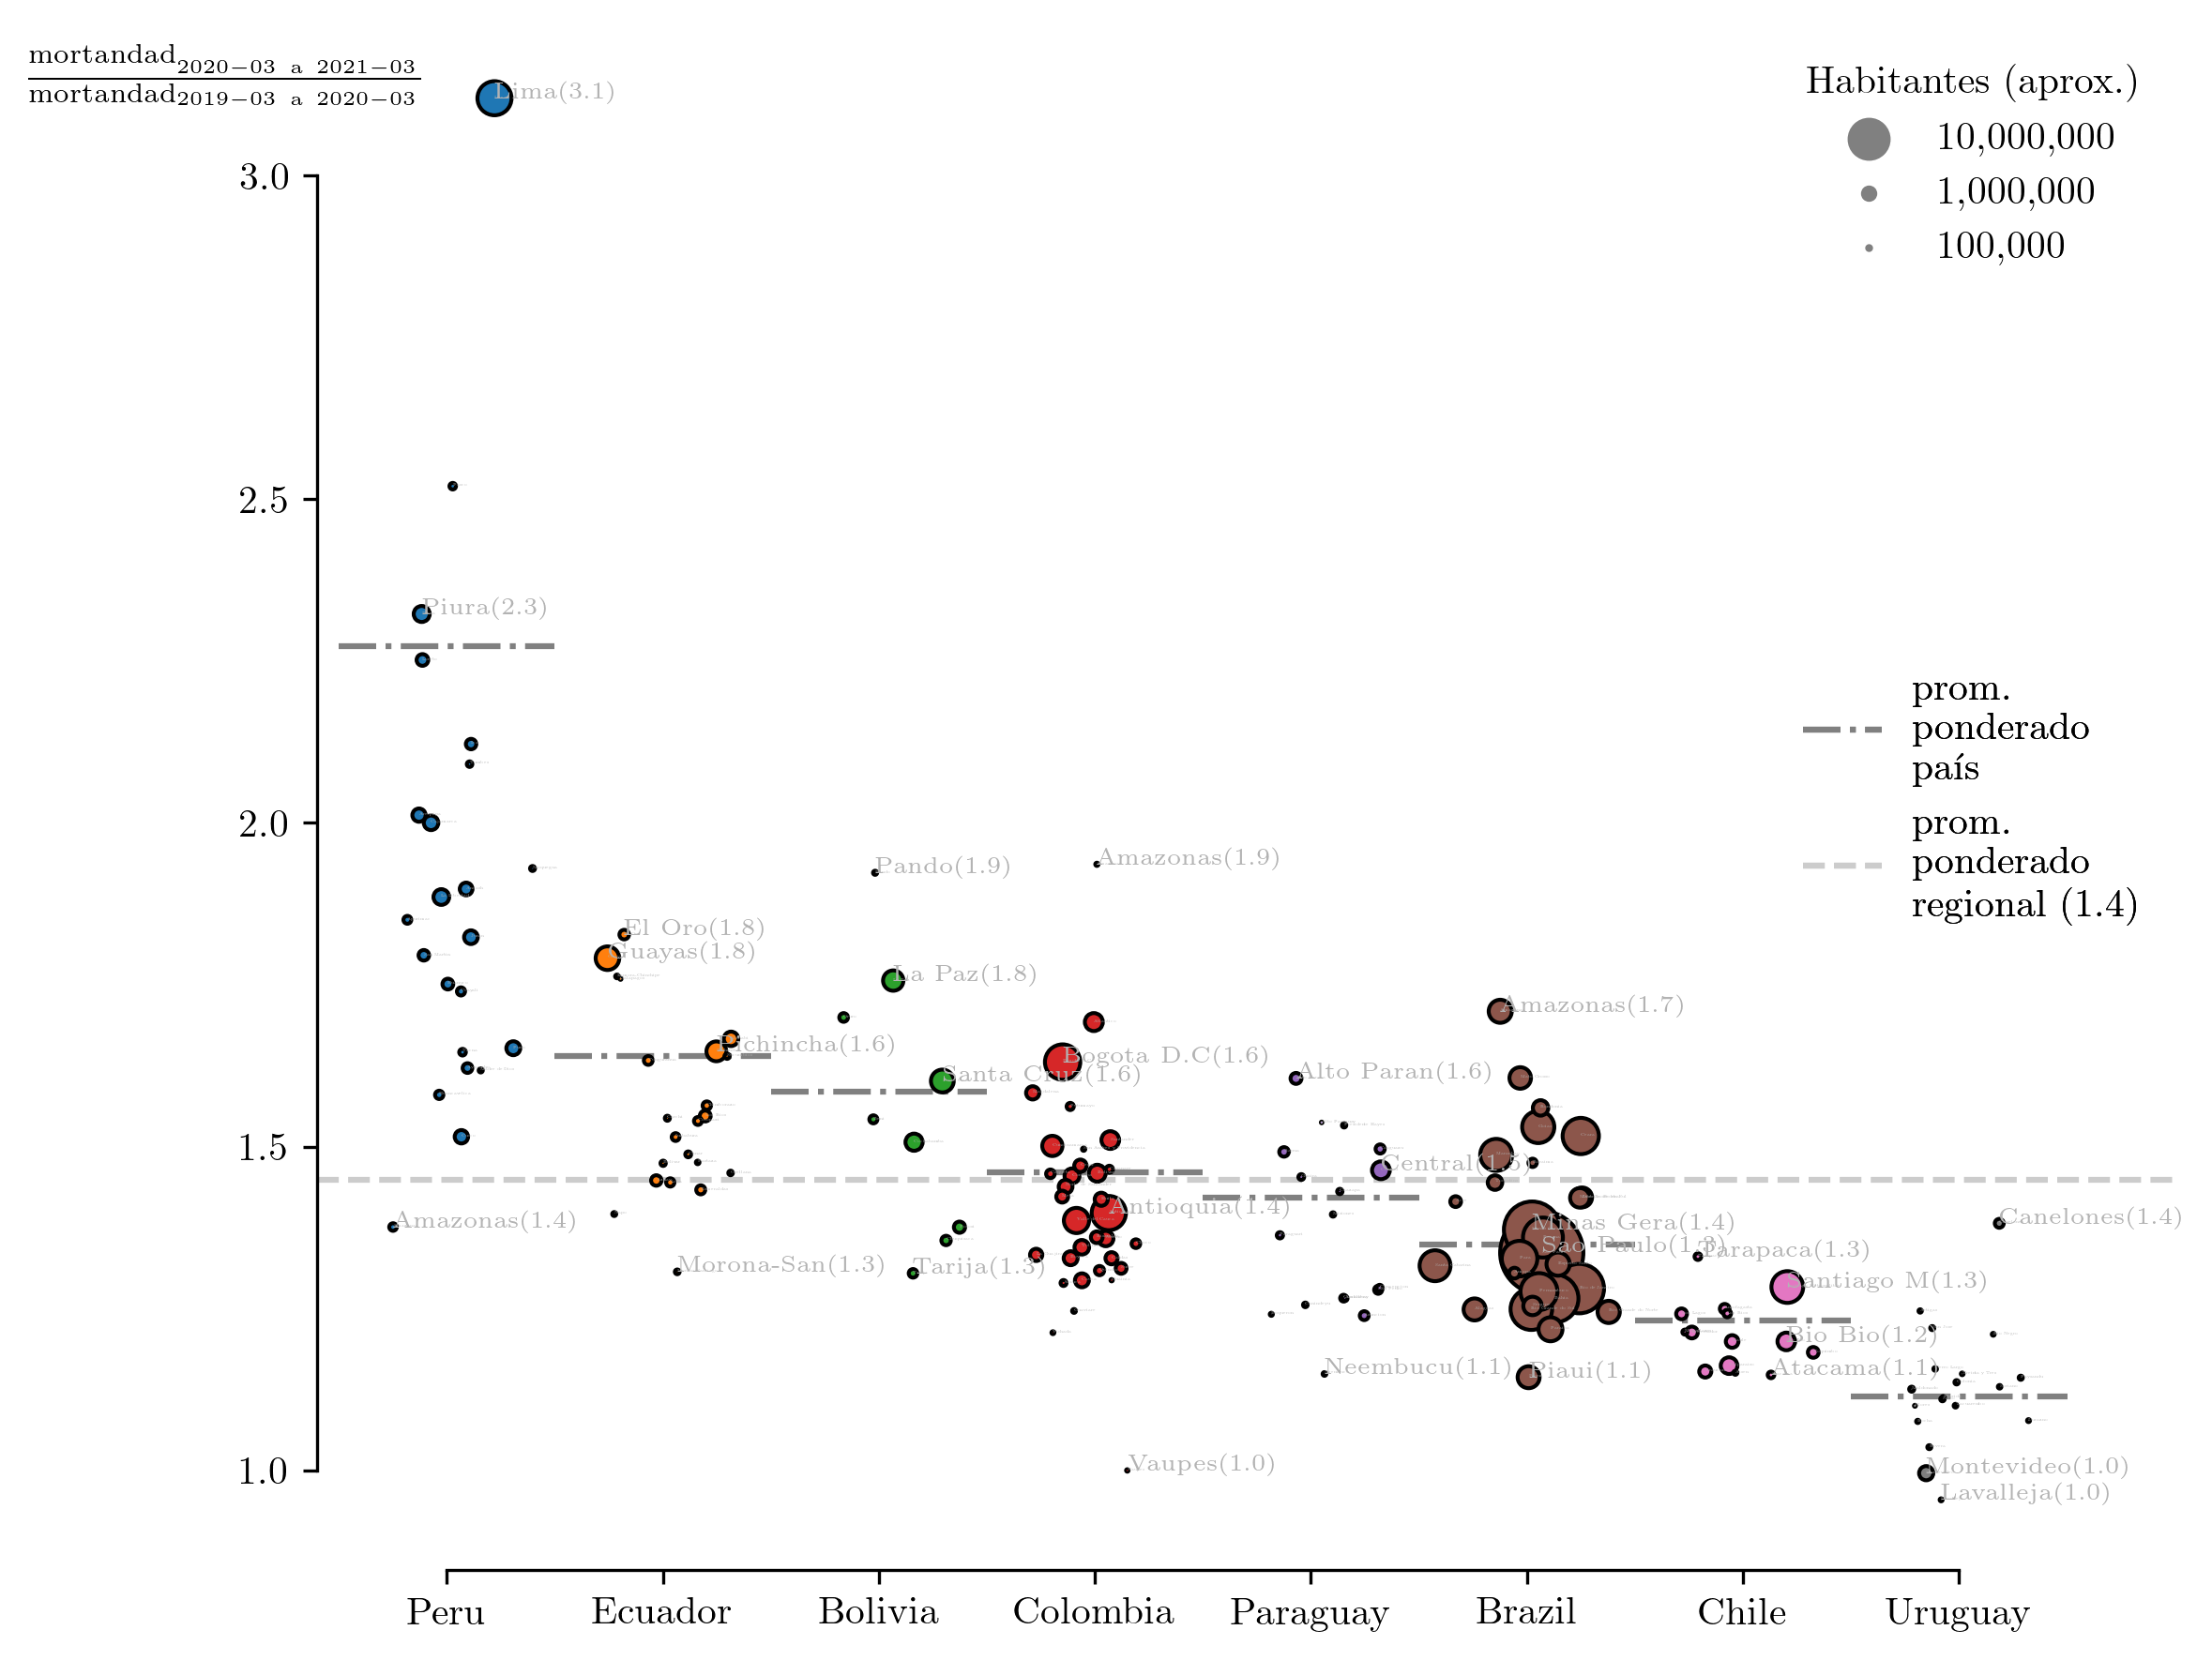

In [573]:
np.random.seed(0)
d1[R] = np.random.randn(len(d1))
# s1 = d1.sort_values(P,ascending=False).head(20)
s1 = d1.sort_values(P,ascending=False).head(20)
Me = (d1[P]*d1[PR]).sum()/d1[P].sum()
cm = plt.get_cmap('tab10')




f,ax = plt.subplots(dpi=300,figsize=(8,6))
# ax.set_ylim(-0,3)
for nn in range(len(dic)):
# nn = 0
    _d = d1[d1[N]==nn].sort_values(P,ascending=False)


    ax.scatter(x=_d[R]/6+nn,y=_d[PR],s=_d[P]/SS,edgecolor='k',facecolor=cm(nn))
    
    me = (_d[P]*_d[PR]).sum()/_d[P].sum()

   
    medline = ax.hlines(y=[me],xmin=nn-.5,xmax=nn+.5,color='.5',ls='-.',zorder=-4)
    
    __d0 = _d.sort_values(PR,ascending=False)[:2]
    __d1 = _d.sort_values(PR,ascending=False)[-1:]
    
    _d2 = pd.concat([__d0,__d1])
    

ax.set_xticks(list(dic.values()));
ax.set_xticklabels(list(dic.keys()),ha='center',rotation=0);

me_reg = ax.axhline(Me,c='.8',ls='--',zorder=-5)

sns.despine(fig=f,trim=True)

LL = 50
ll = np.array([100,90,85,81])/LL

HAB = np.array([1e7,1e6,1e5])

for h in HAB:
    ax.scatter(np.nan,np.nan,s=h/SS,label=f'{int(h):,}',c='.5')

# ax.set_ylim(y1,y2)



for i,r in labs.iterrows():
#     xx = r[NN]/600
    ax.text(r[N]+r[R]/6,
            r[PR],
            f'{r[M][:10]}({r[PR]:.1f})',c='.7',zorder=11,fontsize=r[NN]/SS+6)

    
for i,r in d1.iterrows():

    ax.text(r[N]+r[R]/6,
            r[PR],r[M],c='.7',zorder=10,fontsize=1)


ax.set_xlim(-.6,8)

ax.legend(frameon=False,title='Habitantes (aprox.)',loc=1)
_leg = ax.get_legend()

leg_ = plt.legend([medline,me_reg],['prom.\nponderado\npaís',f'prom.\nponderado\nregional ({Me:.1f})'],
                  loc='center right',frameon=False)
ax.add_artist(leg_)
ax.add_artist(_leg)


ax.set_ylabel(
    r'$\frac{\rm{mortandad}_{_{2020-03\ a\ 2021-03}}}{\rm{mortandad}_{^{2019-03\ a\ 2020-03}}}$',
    rotation=0,
    ha='center',
#     loc = 'top'
    y=.95
)

f.tight_layout()

f.savefig('scatter_pais.png')
f.savefig('scatter_pais.pdf')

In [524]:
_leg

In [ ]:
leg.